# SBI for the parameters of a line fit
The goal is to do inference and then sample from the inferred parameters to build a posterior predictive check (of y). Then, measure the distribution of y given x, and from this return some sort of error interval.

The google colab version of this notebook: https://colab.research.google.com/drive/1tpBs6MlmNk2EVPfPGfvBJxifMdJh9JNN 

## 1 Import all the things

In [1]:
## first, import all the necessary modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [2]:
import sbi
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.analysis import run_sbc, sbc_rank_plot, check_sbc, pairplot
from sbi.inference.base import infer
import torch

In [3]:
# this is necessary to import modules from this repo
import sys
sys.path.append('..')
from src.scripts import models, utils, train

In [4]:
# remove top and right axis from plots
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False

## 2 Define and test out the simulator
Like any good SBI code, you should start with the simulator. Here, each invocation of the simulator will produce a set of noisy points along a line. In other words, each invocation is defined by a noise width, m, and b.

In [5]:
true_sigma = 10
def simulator(thetas):#, percent_errors):
    # convert to numpy array (if tensor):
    thetas = np.atleast_2d(thetas)
    # Check if the input has the correct shape
    if thetas.shape[1] != 2:
        raise ValueError("Input tensor must have shape (n, 2) where n is the number of parameter sets.")

    # Unpack the parameters
    if thetas.shape[0] == 1:
        # If there's only one set of parameters, extract them directly
        m, b = thetas[0, 0], thetas[0, 1]
    else:
        # If there are multiple sets of parameters, extract them for each row
        m, b = thetas[:, 0], thetas[:, 1]
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    # I'm thinking sigma could actually be a function of x
    # if we want to get fancy down the road
    # Generate random noise (epsilon) based on a normal distribution with mean 0 and standard deviation sigma
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size=(len(x), thetas.shape[0]))
    
    # Initialize an empty array to store the results for each set of parameters
    y = np.zeros((len(x), thetas.shape[0]))
    for i in range(thetas.shape[0]):
        m, b = thetas[i, 0], thetas[i, 1]
        y[:, i] = m * x + b + ε[:, i]
    return torch.Tensor(y.T)

def simulator_no_noise(thetas):#, percent_errors):
    # convert to numpy array (if tensor):
    thetas = np.atleast_2d(thetas)
    # Check if the input has the correct shape
    if thetas.shape[1] != 2:
        raise ValueError("Input tensor must have shape (n, 2) where n is the number of parameter sets.")

    # Unpack the parameters
    if thetas.shape[0] == 1:
        # If there's only one set of parameters, extract them directly
        m, b = thetas[0, 0], thetas[0, 1]
    else:
        # If there are multiple sets of parameters, extract them for each row
        m, b = thetas[:, 0], thetas[:, 1]
    x = np.linspace(0, 100, 101)
    # Initialize an empty array to store the results for each set of parameters
    y = np.zeros((len(x), thetas.shape[0]))
    for i in range(thetas.shape[0]):
        m, b = thetas[i, 0], thetas[i, 1]
        y[:, i] = m * x + b 
    return torch.Tensor(y.T)

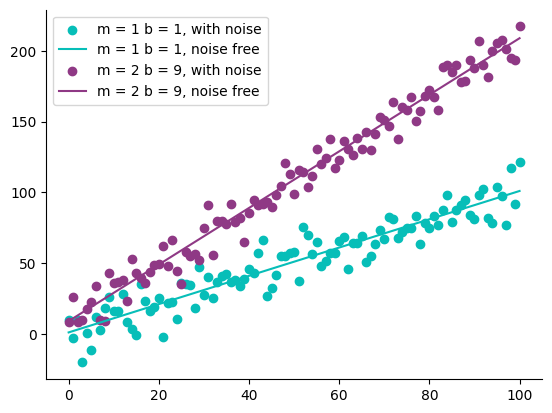

In [6]:
plt.scatter(np.linspace(0, 100, 101),
            np.array(simulator([1, 1])), color = '#07BEB8',
            label = 'm = 1 b = 1, with noise')
plt.plot(np.linspace(0, 100, 101),
         np.array(simulator_no_noise([1, 1]))[0], color = '#07BEB8',
         label = 'm = 1 b = 1, noise free')
plt.scatter(np.linspace(0, 100, 101),
            np.array(simulator([2, 9])), color = '#8F3985',
            label = 'm = 2 b = 9, with noise')
plt.plot(np.linspace(0, 100, 101),
         np.array(simulator_no_noise([2, 9]))[0], color = '#8F3985',
         label = 'm = 2 b = 9, noise free')
plt.legend()
plt.show()

## 3 Generate data
This part is a placeholder for future work - 

Each data "point" is a set of points corresponding to a slope and intercept. The potential future hierarchical aspect of this is inferring things about the distribution of lines in the universe.

The effective data length is 1000 x 100 (because there are 100 x points per each data point).

In [7]:
length_df = 1000
xs = np.zeros((length_df, 2))
ys = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.normal(loc=1, scale=1)
    b = rs.normal(loc=0, scale=10)
    #sigma = abs(rs.normal(loc=0, scale=10))
    thetas = [m, b]
    xs[r,:] = thetas
    ys.append(simulator(thetas))

## 4 Define the prior
And then visualize them.

In [9]:
num_dim = 2

low_bounds = torch.tensor([0, -10])
high_bounds = torch.tensor([10, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)

In [63]:
# let's color-code
m_color = '#9C92A3'
b_color = '#0F5257'

<Figure size 640x480 with 0 Axes>

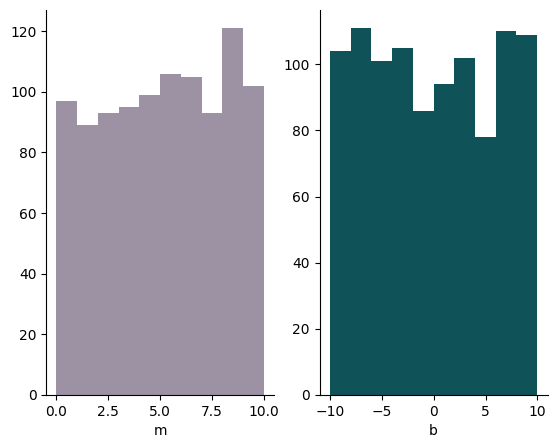

In [30]:
m_sample = []
b_sample = []

for i in range(1000):
  samp = prior.sample()
  m_sample.append(np.array(samp[0]))
  b_sample.append(np.array(samp[1]))

plt.clf()
fig = plt.figure(figsize = (10,5))
ax0 = fig.add_subplot(131)
ax0.hist(m_sample, color = m_color)
ax0.set_xlabel('m')
ax1 = fig.add_subplot(132)
ax1.hist(b_sample, color = b_color)
ax1.set_xlabel('b')
plt.show()

## 5 Run SBI
Normalizing flow; neural network magic.

In [102]:
posterior = infer(simulator, prior, "SNPE", num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 115 epochs.

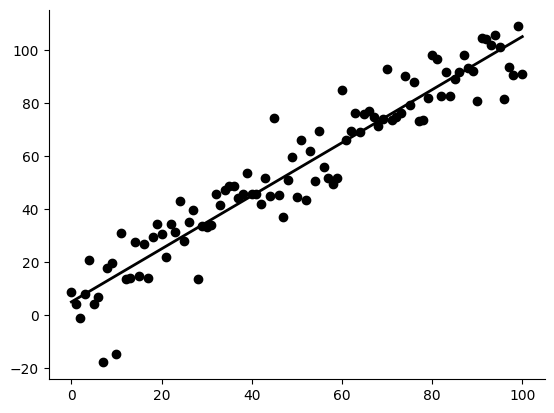

In [103]:
# generate a true dataset
theta_true = [1, 5]
y_true = simulator(theta_true)
y_true_no_noise = simulator_no_noise(theta_true)

# and visualize it
plt.clf()
plt.scatter(np.linspace(0, 100, 101),
            np.array(y_true), color = 'black')
plt.plot(np.linspace(0, 100, 101),
            np.array(y_true_no_noise)[0], color = 'black')
plt.show()



Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

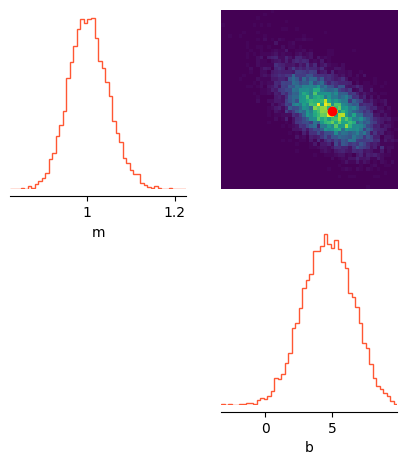

In [120]:
# sample from the posterior
posterior_samples_1 = posterior.sample((10000,), x = y_true)
# that last little part is conditioning on a data value
# plot posterior samples
fig, axes = pairplot(
    posterior_samples_1, 
    labels = ['m', 'b'],
    #limits = [[0,10],[-10,10],[0,10]],
    truths = theta_true,
    figsize=(5, 5)
)
axes[0, 1].plot([theta_true[1]], [theta_true[0]], marker="o", color="red")

## 6 Posterior predictive
Okay but these are just the parameters. What we really want is the posterior predictive check, which is built by running draws from the posterior through the simulator again.

With or without noise in the simulator? I think without because otherwise it would be double counting uncertainty.

In [105]:
# first the way of the sbi module
# Generate predictive samples by simulating from posterior samples.
posterior_predictive_samples = simulator(posterior_samples_1)
posterior_predictive_samples_no_noise = simulator_no_noise(posterior_samples_1)

The output format for the posterior predictive samples is 101 values from a line. The best way to visualize this is to write my own plotting module (as opposed to using sbi's pairplot module). 

(10000, 101)
(10000, 101)


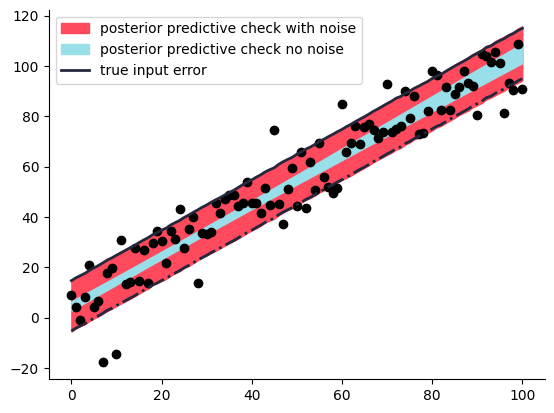

In [106]:
# also go through and plot one sigma interval
# plot the true values
plt.clf()
xs_sim = np.linspace(0, 100, 101)
ys_sim = np.array(posterior_predictive_samples)
ys_sim_no_noise =  np.array(posterior_predictive_samples_no_noise)

print(np.shape(ys_sim))
print(np.shape(ys_sim_no_noise))

plt.fill_between(xs_sim,
                 np.mean(ys_sim, axis = 0) - 1 * np.std(ys_sim, axis = 0),
                 np.mean(ys_sim, axis = 0) + 1 * np.std(ys_sim, axis = 0),
                 color = '#FF495C', label = 'posterior predictive check with noise')

plt.fill_between(xs_sim,
                 np.mean(ys_sim_no_noise, axis = 0) - 1 * np.std(ys_sim_no_noise, axis = 0),
                 np.mean(ys_sim_no_noise, axis = 0) + 1 * np.std(ys_sim_no_noise, axis = 0),
                 color = '#98DFEA', label = 'posterior predictive check no noise')

plt.plot(xs_sim, np.mean(ys_sim, axis = 0) + true_sigma,
         color = '#25283D', label = 'true input error')
plt.plot(xs_sim, np.mean(ys_sim, axis = 0) - true_sigma,
         color = '#25283D')
plt.scatter(xs_sim,
            np.array(y_true), 
            color = 'black')#'#EFD9CE')  

plt.legend()

plt.show()

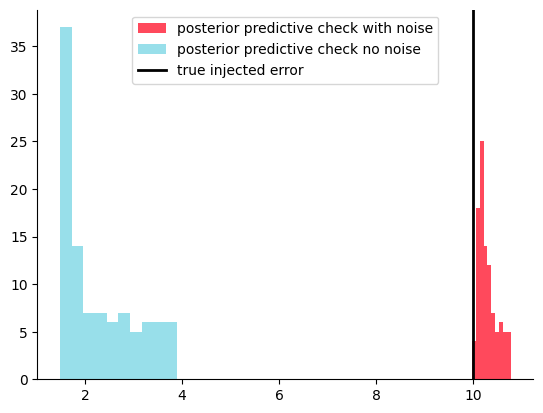

In [107]:
# Another way to look at this would be to plop it on its side and look at the sigma values at each x
plt.hist(np.std(ys_sim, axis = 0),
         label = 'posterior predictive check with noise',
         color = '#FF495C',
         bins = 10)
plt.hist(np.std(ys_sim_no_noise, axis = 0),
         label = 'posterior predictive check no noise',
         color = '#98DFEA',
         bins = 10)
plt.axvline(x = true_sigma,
            color = 'black',
            label = 'true injected error')
plt.legend()
plt.show()

## 7 Simulation-based calibration (SBC)
Simulation-based calibration is a set of tools built into Mackelab's sbi interface. It provides a way to compare the inferred posterior distribution to the true parameter values. It performs multiple instances of drawing parameter values from the prior, running these through the simulator, and comparing these values to those obtained from the run of inference. Importantly, this will not diagnose what's going on for one draw from the posterior (ie at one data point). Instead, it's meant to give an overall sense of the health of the posterior learned from SBI.

This technique is based on rank plots. Rank plots are produced from comparing each posterior parameter draw (from the prior) to the distribution of parameter values in the posterior. There should be a 1:1 ranking, aka these rank plots should be similar in shape to a uniform distribution.

In [108]:
num_sbc_runs = 1_000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
ys = simulator(thetas)

In [109]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    thetas, ys, posterior, num_posterior_samples=num_posterior_samples
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [110]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)
check_stats

{'ks_pvals': tensor([0.0930, 0.0056]),
 'c2st_ranks': tensor([0.5675, 0.5780]),
 'c2st_dap': tensor([0.4970, 0.5125])}

The ks pvalues are vanishingly small here, so we can reject the null hypothesis (of the marginal rank distributions being equivalent to an uniform distribution). The inference clearly went wrong.
In terms of the c2st_ranks diagnostic; this is a nonparametric two sample test from training on and testing on the rank versus uniform distributions and distinguishing between them. If values are close to 0.5, it is hard to distinguish.
The data-averaged posterior value compares to the prior; if these values are close to 0.5, dap is like the prior distribution.

Help on function sbc_rank_plot in module sbi.analysis.plot:

sbc_rank_plot(ranks: Union[torch.Tensor, numpy.ndarray, List[torch.Tensor], List[numpy.ndarray]], num_posterior_samples: int, num_bins: Optional[int] = None, plot_type: str = 'cdf', parameter_labels: Optional[List[str]] = None, ranks_labels: Optional[List[str]] = None, colors: Optional[List[str]] = None, fig: Optional[matplotlib.figure.Figure] = None, ax: Optional[matplotlib.axes._axes.Axes] = None, figsize: Optional[tuple] = None, kwargs: Dict = {}) -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
    Plot simulation-based calibration ranks as empirical CDFs or histograms.
    
    Additional options can be passed via the kwargs argument, see _sbc_rank_plot.
    
    Args:
        ranks: Tensor of ranks to be plotted shape (num_sbc_runs, num_parameters), or
            list of Tensors when comparing several sets of ranks, e.g., set of ranks
            obtained from different methods.
        num_bins: number o

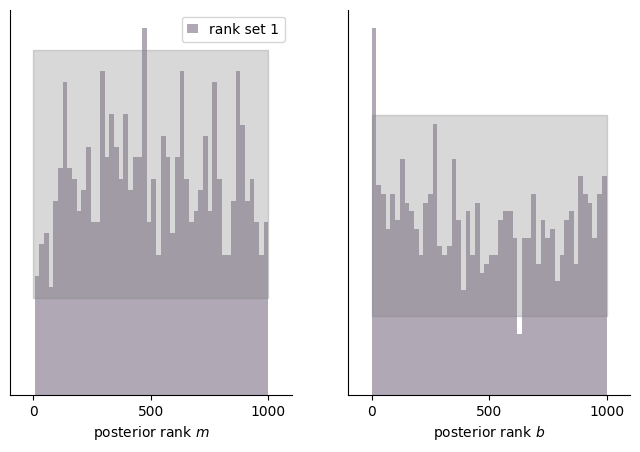

In [111]:
help(sbc_rank_plot)
_ = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,
    parameter_labels=['$m$', '$b$'],
    colors=[m_color, b_color]
)

If the rank plots are consistent with being uniform, the red bars should fall mostly within the grey area. The grey area is the 99% confidence interval for the uniform distribution, so if the rank histogram falls outside this for more than 1 in 100 bars, that means it is not consistent with an uniform distribution (which is what we want). 

A central peaked rank plot could be indicative of a posterior that's too concentrated whereas one with wings is a posterior that is too dispersed. Conversely, if the distribution is shifted left or right that indicates that the parameters are biased.

If it's choppy, it could be indicative of not doing enough sampling. A good rule of thumb is N / B ~ 20, where N is the number of samples and B is the number of bins.

Help on function sbc_rank_plot in module sbi.analysis.plot:

sbc_rank_plot(ranks: Union[torch.Tensor, numpy.ndarray, List[torch.Tensor], List[numpy.ndarray]], num_posterior_samples: int, num_bins: Optional[int] = None, plot_type: str = 'cdf', parameter_labels: Optional[List[str]] = None, ranks_labels: Optional[List[str]] = None, colors: Optional[List[str]] = None, fig: Optional[matplotlib.figure.Figure] = None, ax: Optional[matplotlib.axes._axes.Axes] = None, figsize: Optional[tuple] = None, kwargs: Dict = {}) -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
    Plot simulation-based calibration ranks as empirical CDFs or histograms.
    
    Additional options can be passed via the kwargs argument, see _sbc_rank_plot.
    
    Args:
        ranks: Tensor of ranks to be plotted shape (num_sbc_runs, num_parameters), or
            list of Tensors when comparing several sets of ranks, e.g., set of ranks
            obtained from different methods.
        num_bins: number o

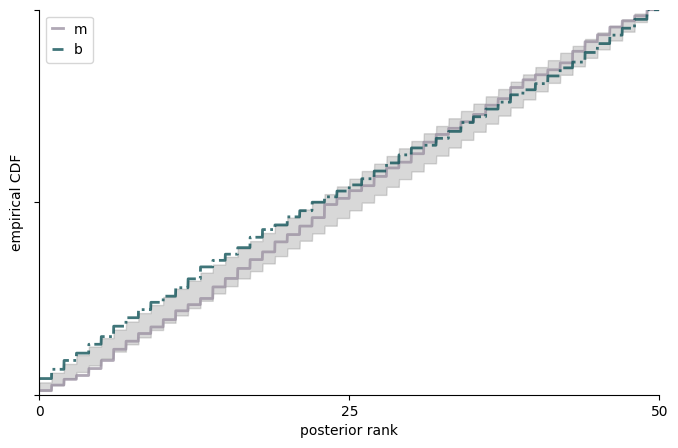

In [112]:
help(sbc_rank_plot)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf", parameter_labels=["m","b"], colors = [m_color, b_color])

This is a different way to visualize the same thing. Essentially, the grey is the 95% confidence interval for an uniform distribution. The cdf for the posterior rank distributions (in color) should fall within this band.

In [113]:
def calculate_coverage_fraction(posterior, x_observed, truth_array, percentile_list, samples_per_inference = 1000):
    """
    posterior --> the trained posterior
    x_observed --> the data used for inference
    truth_array --> true parameter values
    """
    # this holds all posterior samples for each inference run
    all_samples = np.empty((len(x_observed), samples_per_inference, np.shape(truth_array)[1]))
    count_array = []
    for i in range(len(x_observed)):
        # sample from the trained posterior n_sample times for each observation
        samples = posterior.sample(sample_shape=(samples_per_inference,), x=x_observed[i]).cpu()

        '''
        # plot posterior samples
        fig, axes = pairplot(
            samples, 
            labels = ['m', 'b'],
            #limits = [[0,10],[-10,10],[0,10]],
            truths = truth_array[i],
            figsize=(5, 5)
        )
        axes[0, 1].plot([truth_array[i][1]], [truth_array[i][0]], marker="o", color="r")
        '''
        
        all_samples[i] = samples
        count_vector = []
        # step through the percentile list
        for ind, cov in enumerate(percentile_list):
            percentile_l = 50.0 - cov/2
            percentile_u = 50.0 + cov/2
            # find the percentile for the posterior for this observation
            # this is n_params dimensional
            # the units are in parameter space
            confidence_l = np.percentile(samples.cpu(), percentile_l, axis=0)
            confidence_u = np.percentile(samples.cpu(), percentile_u, axis=0)
            # this is asking if the true parameter value is contained between the
            # upper and lower confidence intervals
            # checks separately for each side of the 50th percentile
            count = np.logical_and(confidence_u - truth_array.T[:,i] > 0, truth_array.T[:,i] - confidence_l > 0)
            count_vector.append(count)
        # each time the above is > 0, adds a count
        count_array.append(count_vector)
    count_sum_array = np.sum(count_array, axis=0)
    frac_lens_within_vol = np.array(count_sum_array)
    return all_samples, np.array(frac_lens_within_vol)/len(x_observed)

In [114]:
percentile_array = np.linspace(0,100,21)
samples, frac_array = calculate_coverage_fraction(posterior,
                                                  ys,
                                                  np.array(thetas),
                                                  percentile_array,
                                                  samples_per_inference = 1000)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

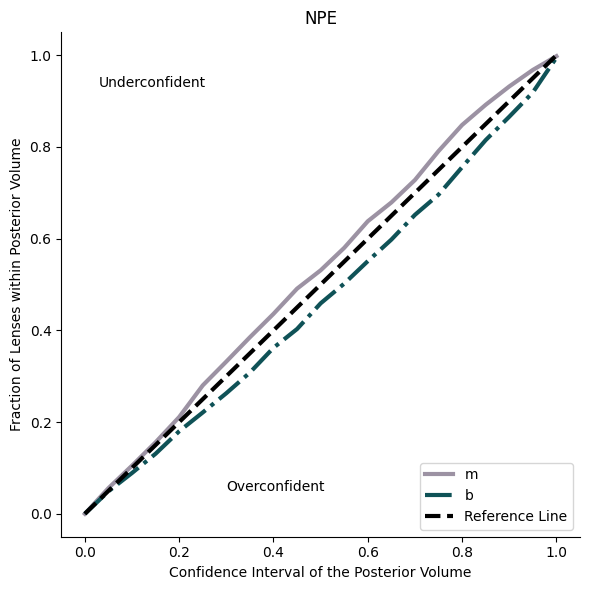

In [115]:
percentile_array_norm = np.array(percentile_array)/100

# Create a cycler with hexcode colors and linestyles
color_cycler = cycler(color=[m_color, b_color])
linestyle_cycler = cycler(linestyle=['-', '-.'])

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Use itertools.cycle to loop through colors and linestyles
color_cycle = iter(color_cycler)
linestyle_cycle = iter(linestyle_cycler)
label_list = ['m', 'b']
# Iterate over the second dimension of frac_array
for i in range(frac_array.shape[1]):
    color_style = next(color_cycle)['color']
    linestyle_style = next(linestyle_cycle)['linestyle']
    ax.plot(percentile_array_norm, frac_array[:, i], alpha=1.0, lw=3, linestyle=linestyle_style, color=color_style, label=label_list[i])

ax.plot([0, 0.5, 1], [0, 0.5, 1], 'k--', lw=3, zorder=1000, label='Reference Line')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.text(0.03, 0.93, 'Underconfident', horizontalalignment='left')
ax.text(0.3, 0.05, 'Overconfident', horizontalalignment='left')
ax.legend(loc='lower right')
ax.set_xlabel('Confidence Interval of the Posterior Volume')
ax.set_ylabel('Fraction of Lenses within Posterior Volume')
ax.set_title('NPE')
plt.tight_layout()
plt.show()

## 8 Visualize the inference results from the SBC analysis
We've already saved samples, let's compare the inferred (and associated error bar) parameters from each of the data points we used for the SBC analysis.

In [116]:

print(np.shape(samples), np.shape(thetas))
percentile_16_m = []
percentile_50_m = []
percentile_84_m = []
percentile_16_b = []
percentile_50_b = []
percentile_84_b = []
for i in range(len(samples[0])):
    #print(np.shape(samples[i]))
    #STOP
    percentile_16_m.append(np.percentile(samples[i,0], 16))
    percentile_50_m.append(np.percentile(samples[i,0], 50))
    percentile_84_m.append(np.percentile(samples[i,0], 84))
    percentile_16_b.append(np.percentile(samples[i,1], 16))
    percentile_50_b.append(np.percentile(samples[i,1], 50))
    percentile_84_b.append(np.percentile(samples[i,1], 84))
    


(1000, 1000, 2) torch.Size([1000, 2])


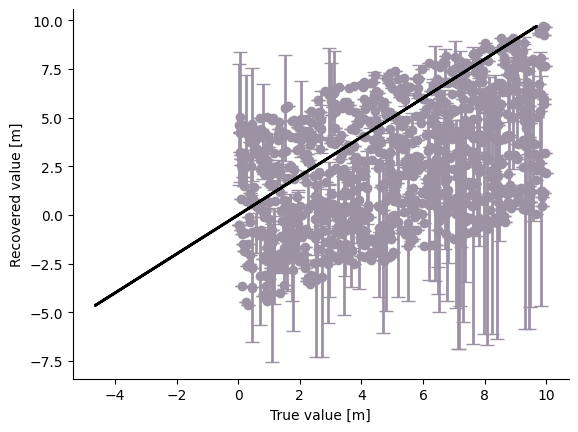

In [117]:
yerr_minus = [mid - low for (mid, low) in zip(percentile_50_m, percentile_16_m)]
yerr_plus = [high - mid for high, mid in zip(percentile_84_m, percentile_50_m)]

# Randomly set half of the error bars to zero
random_indices = np.random.choice(len(yerr_minus), int(len(yerr_minus) // 1.15), replace=False)
for idx in random_indices:
    yerr_minus[idx] = 0
    yerr_plus[idx] = 0

plt.errorbar(np.array(thetas[:,0]),
             percentile_50_m,
             yerr = [yerr_minus, yerr_plus],
             linestyle = 'None',
             color = m_color,
             capsize = 5)
plt.scatter(np.array(thetas[:,0]), percentile_50_m, color = m_color)
plt.plot(percentile_50_m, percentile_50_m, color = 'k')
plt.xlabel('True value [m]')
plt.ylabel('Recovered value [m]');

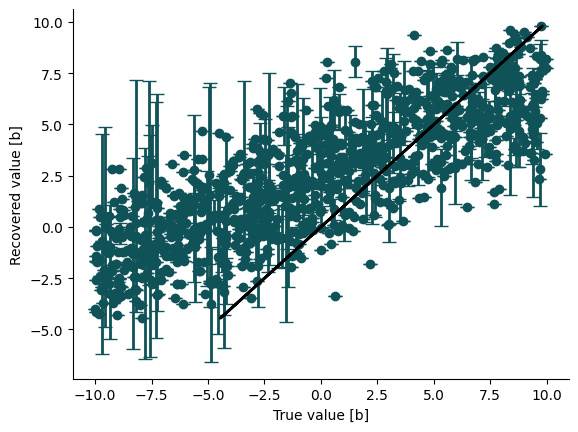

In [118]:
plt.scatter(np.array(thetas[:,1]), percentile_50_b, color = b_color)
yerr_minus = [mid - low for (mid, low) in zip(percentile_50_b, percentile_16_b)]
yerr_plus = [high - mid for high, mid in zip(percentile_84_b, percentile_50_b)]

# Randomly set half of the error bars to zero
random_indices = np.random.choice(len(yerr_minus), int(len(yerr_minus) // 1.15), replace=False)
for idx in random_indices:
    yerr_minus[idx] = 0
    yerr_plus[idx] = 0

plt.errorbar(np.array(thetas[:,1]),
             percentile_50_b,
             yerr = [yerr_minus, yerr_plus],
             linestyle = 'None',
             color = b_color,
             capsize = 5)
plt.plot(percentile_50_b, percentile_50_b, color = 'black')
plt.xlabel('True value [b]')
plt.ylabel('Recovered value [b]');